In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats

In [2]:
'''Load JSON files'''
f = open('../clm-runscripts/logs/saved-data-copy.json')
data = json.load(f)
data_dict = dict(data)

In [3]:
case_name = 'derecho_wte_calib'
calib_year = 2015

In [4]:
'''Import Model Results'''
file_dir = '/glade/derecho/scratch/marielj/archive/' + case_name + '/lnd/hist/'
files = glob(file_dir + case_name + '.clm2.h1.*.nc')

data = xr.open_mfdataset(files, use_cftime = True)

In [5]:
data

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 1, time: 2556,
                   hist_interval: 2, lndgrid: 1, levsoi: 20)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2011-01-01 00:00:00 ... 2018-01-01 00:00:00
Dimensions without coordinates: hist_interval, lndgrid, levsoi
Data variables: (12/30)
    mcdate        (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mcsec         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mdcur         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    mscur         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    nstep         (time) int32 dask.array<chunksize=(365,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(365, 2), meta=np.ndarray>
    ...            ...
    SNOW          (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    SOILICE       (time, levsoi, lndgrid) float32 dask.array<chunksize=(365, 20, 1), meta=np.ndarray>
    TSA           (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(365, 25, 1), meta=np.ndarray>
    ZWT           (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
    ZWT_PERCH     (time, lndgrid) float32 dask.array<chunksize=(365, 1), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/16/24 10:33:44
    source:                                    Community Land Model CLM4.0
    hostname:                                  derecho
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1

In [6]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[dt1.DATE.dt.year == calib_year]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)

In [7]:
'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

# Pull out 2017 year
stream = dt2[dt2.Date.dt.year == calib_year]
stream = stream[stream.Watershed == 'S2'].reset_index(drop = True)

#Convert cm/day to mm/sec
m = 10/(60*60*24)
stream['Flow_mms'] = m*stream['Flow (cm/day)']

In [8]:
'''Convert WTE to WTD'''
wte['WTD'] = -(422.0 - wte.WTE)

In [9]:
'''FUNCTIONS'''
def nse(predictions, targets):
    return (1-(np.sum((targets-predictions)**2))/np.sum((targets-np.mean(targets))**2))

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def spearman(x, y):
    res = scipy.stats.spearmanr(x, y).statistic
    return res

KeyError: '17'

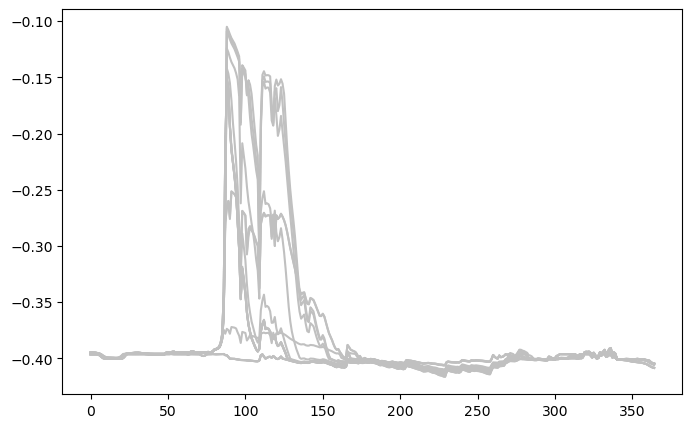

In [10]:
'''Plot model results'''
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

#Plot CLM opt data
for i in range(0, len(data)-1):
    if(i == 0):
        ax.plot(data_dict[str(i)]['data']['timeseries'], color = 'silver', label = 'CLM')
    else:
        ax.plot(data_dict[str(i)]['data']['timeseries'], color = 'silver')

#Plot Marcell data
ax.plot(wte.WTD, color = 'blue', label ='MEF')

#Plot spcifics
ax.set_xlabel('Date of the Year (2017)')
ax.set_ylabel('Water Table Depth')
plt.title('Optimal calibration CLM ensemble, no modifications')
plt.xlim(0, 365)
plt.legend()

In [25]:
#Flatten
clm_wte = [item for sublist in data_dict['1']['data']['timeseries'] for item in sublist]

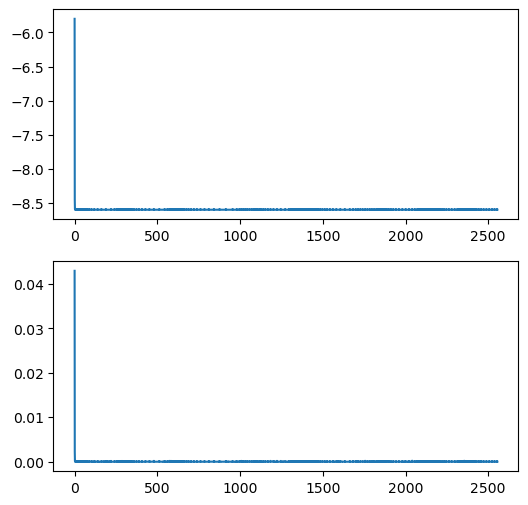

In [11]:
'''General Model Plot'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (6, 6))

#Plot CLM hillslope - column level
ax1.plot(-data.ZWT)

#Plot CLM hillslope - runoff
ax2.plot(data.QRUNOFF)

In [14]:
'''WTE Correlation'''
meas_wt = wte.WTD
mod_wt = -data.ZWT[(data.time.dt.year == calib_year)].values.reshape(365)

In [15]:
rsquared(meas_wt, mod_wt)

0.0012176944045499932

In [16]:
nse(mod_wt, meas_wt)

-4583.909513973229

In [17]:
spearman(mod_wt, meas_wt)

-0.029104310044204836

In [18]:
'''Streamflow Correlation'''
meas_stream = stream.Flow_mms
mod_stream = data.QRUNOFF[(data.time.dt.year == calib_year)].values.reshape(365)

In [19]:
rsquared(meas_stream, mod_stream)

0.02481282418042362

In [20]:
nse(mod_stream, meas_stream)

-14.050745980180588

In [21]:
spearman(mod_stream, meas_stream)

0.30009898750069636